In [30]:
"""
Hello
"""
import os
from itertools import cycle
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras import Model
from tensorflow.types.experimental import TensorLike

from src.utils.box_cutter import BoundingBox_Processor
from src.utils.classes import CategoricalDataGen
from src.utils.data_worker import LabelWorker, init_COCO
from src.utils.funcs import *

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
%aimport src.utils.funcs
%aimport src.utils.box_cutter
%aimport src.utils.classes
%aimport src.utils.data_worker

In [7]:
color = cycle(["orange", "crimson", "tomato",
               "springgreen", "aquamarine", 
               "fuchsia", "deepskyblue", 
               "mediumorchid", "gold"])
images = sorted(glob("./data/images/train/*"))

In [8]:
data = init_COCO("./data/", ['train', 'val', 'test'])
box_cutter = BoundingBox_Processor()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [9]:
labeler = LabelWorker(data_name='train',
                      coco_obj=data,
                      image_path='./data/images/',
                      input_size=(1440, 1920),
                      target_size=(384, 512))

In [11]:
num_anchors = 9
labels = labeler.label_list()[:16]
anchors = stack_anchors(generate_anchors(labels, boxes_per_cell=num_anchors, random_state=42))
label_corners = get_corners(labels)
anchor_corners = get_corners(anchors)
label_edges = get_edges(label_corners)
anchor_edges = get_edges(anchor_corners)
print(f"labels shape: {labels.shape}")
print(f"label_corners shape: {label_corners.shape}")
print(f"label_edges shape: {label_edges.shape}")
print(f"anchors shape: {anchors.shape}")
print(f"anchor_corners shape: {anchor_corners.shape}")
print(f"anchor_edges shape: {anchor_edges.shape}")

labels shape: (16, 18, 19)
label_corners shape: (16, 18, 4, 2)
label_edges shape: (16, 18, 4, 2, 2)
anchors shape: (16, 972, 5)
anchor_corners shape: (16, 972, 4, 2)
anchor_edges shape: (16, 972, 4, 2, 2)


In [25]:
def nonmaxsuppresion(labels, anchors):
    intersection_points, label_corners, anchor_corners = construct_intersection_vertices(labels, anchors) 
    intersection = intersection_area(intersection_points)
    union = union_area(label_corners, anchor_corners, intersection, num_pumps=9)
    print(f"labels:     {labels.shape}")
    print(f"anchors:    {anchors.shape}")

    giou = calculate_giou(label_corners, anchor_corners, union, intersection)
    print(f"giou:       {giou.shape}")
    sorted = tf.argsort(giou, axis=-1, direction='DESCENDING')
    max_boxes = sorted[:, :, 0]
    print(f"max_boxes: {max_boxes.shape}")
    pred_boxes = tf.gather(anchors, max_boxes, axis=-2, batch_dims=-1)
    print(f"pred_boxes: {pred_boxes.shape}")
    return pred_boxes * labels[:, :, 13]

pred_boxes = nonmaxsuppresion(labels, anchors)

labels:     (16, 18, 19)
anchors:    (16, 972, 5)
giou:       (16, 18, 972)
max_boxes: (16, 18)
pred_boxes: (16, 18, 5)


pred_corners: (16, 18, 4, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

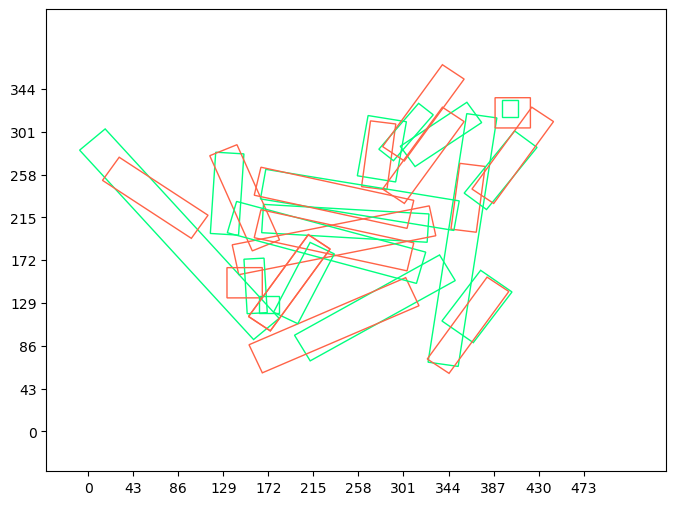

In [41]:
pred_corners = get_corners(pred_boxes) 
print(f"pred_corners: {pred_corners.shape}")
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(
        ylim=[-40, 384+40],
        xlim=[-40, 512+40],
        xticks=list(range(0, 512,int(np.ceil(512/12)))),
        yticks=list(range(0, 384, int(np.ceil(384/9)))),
        )
for i in range(pred_corners.shape[1]):
    ax.add_patch(Polygon(label_corners[1, i], fill=False, edgecolor='springgreen'))
    ax.add_patch(Polygon(pred_corners[1, i], fill=False, edgecolor='tomato'))
plt.show